# FINM 33150 Homework 2: Simple Spread Trading

Sean Lin

Student ID: 12375235

***

## 1 Introduction

In this assignment, a spread trading strategy between two different ETFs is created and backtested. In essence, this strategy will long the spread below a certain threshold and will short the spread above a certain threshold. This is done by shorting the ETF with higher returns and buying the ETF with lower returns on some interval. In addition, take-profit and stop-loss parameters are also used. The choice for these parameters are discussed and analyzed. 

In [1]:
import os 
import datetime 
import quandl 
import numpy as np
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from heapq import heappush, nlargest 

In [2]:
KEY = os.getenv('QUANDL_KEY') # If you want to run the notebook on your own, set this to your own API key 
quandl.ApiConfig.api_key = KEY

## 2 Data

Ticker data for an ETF pair (X, Y) were obtained from the QuoteMedia database with Quandl based on the last two digits of my student ID for Dec 02 2020 through Nov 15 2022. The adjusted closing prices and volumes were retrieved from this data for calculations and setting backtest parameters. More specifically, daily dollar volume was calculated from normal volume and used to calculate a rolling 15- day median. This rolling median is later used to determine position sizing. Fama-French data is also obtained from Ken French's website for the same dates. 

The last digit of my student ID is *5*, hence the following ETF pair was used:

5. SIVR (abrdn Physical Silver Shares ETF) / SLV (iShares Silver Trust)

***

**2.1 Processing Data**

First, the functions `get_data` and `get_ff` are created to obtain ETF price data and Fama-French factor returns respectively. The usage of the functions and comments can be seen below. To use the `get_ff` function, download the CSV named: **Fama/French 3 Factors [Daily]** [here](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

In [4]:
def get_data(ticker, start_date='2020-12-02', end_date='2022-11-15'):
    '''
    Obtains ticker data for a given start and end date 

    Parameters:
        ticker (string): Name of the ticker 
        start_date (string): The start date of the price data (default 2020-12-02)
        end_date (string): The end date of the price data (default 2022-11-15)

    Returns:
        filtered_df (DataFrame): DataFrame consisting of ticker adj. close, dollar volume, and 15-trading-day median with date index 
    '''
    qdata = quandl.get_table('QUOTEMEDIA/PRICES', date={'gte': start_date, 'lte': end_date}, ticker=ticker)
    qdata = qdata.sort_index(ascending=False)
    qdata['dollar volume'] = qdata['adj_close'] * qdata['adj_volume'] # calculation of dollar volume 
    qdata['15-trading-day median'] = qdata['dollar volume'].rolling(15).median() # rolling 15- day dollar volume median 
    filtered_df = qdata[['adj_close','dollar volume','15-trading-day median','date']].set_index('date')
    return filtered_df

In [5]:
def get_ff(filename, start_date='2020-12-02', end_date='2022-11-15'):
    '''
    Obtains Fama-French factor daily returns for a given start and end date  

    Parameters:
        filename (string): CSV file of Fama-French factor daily returns 
        start_date (string): The start date of return data (default 2020-12-02)
        end_date (string): The end date of return data (default 2022-11-15)

    Returns:
        filtered_df (DataFrame): DataFrame consisting of Mkt-RF, SMB, HML, RF factors with date index
    '''
    factors = pd.read_csv(filename)
    factors['Unnamed: 0'] = pd.to_datetime(factors['Unnamed: 0'], format='%Y%m%d')
    factors = factors.rename(columns={'Unnamed: 0' : 'Date'}).set_index('Date')
    filtered_df = factors.loc[start_date:end_date]
    return filtered_df

For generality, the variables are named *X* and *Y* to maintain consistency with the homework pdf. The names can be changed for other ETF pairs if needed. $N_t$ is also defined to be the rolling 15-trading-day median for the ETF X (the ETF with lower liquidity, more specifically defined in a later section).

In [6]:
X = get_data('SIVR')
Y = get_data('SLV')

Nt = X['15-trading-day median']

For ease of convenience, we will also define the variables _prices_ as a DataFrame consisting of the adjusted-close prices of both X and Y. This allows the prices to be in one unified DataFrame, rather than two separate ones.

In [7]:
prices = pd.concat([X['adj_close'], Y['adj_close']], axis=1)
prices.columns = ['X','Y']

***

**2.2 Plotting Data**

Since we have several time-series, it is good practice to plot everything and see if we notice anything. First, we will plot the adj_close prices for both ETFs.

(array([18628., 18718., 18809., 18901., 18993., 19083., 19174., 19266.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10')])

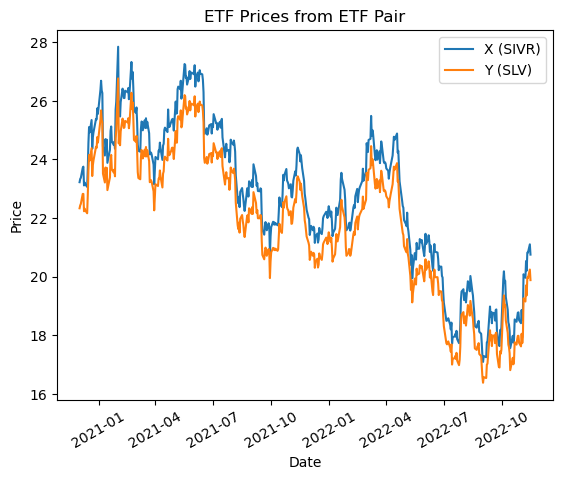

In [8]:
plt.plot(prices, label=['X (SIVR)', 'Y (SLV)'])
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('ETF Prices from ETF Pair')
plt.legend()

plt.xticks(rotation=30)

From the graph, it is observed that SIVR and SLV track each other extremely closely and are extremely correlated. We will quantify this with calculating a correlation coefficient.

In [9]:
corr = prices['X'].corr(prices['Y'])
f'Correlation between X (SIVR) and Y (SLV): {round(corr,3)}'

'Correlation between X (SIVR) and Y (SLV): 1.0'

It's seen that the correlation between SIVR and SLV is 1. They are perfectly correlated. Hence, it makes sense that a spread strategy could work for an ETF pair. If the performance of one ETF strays away from that of the other, we can go long the ETF with the weaker performance and short the ETF with the higher performance. Next, we will plot the dollar volumes to gauge the liquidity for the two ETFs.

(array([18628., 18718., 18809., 18901., 18993., 19083., 19174., 19266.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10')])

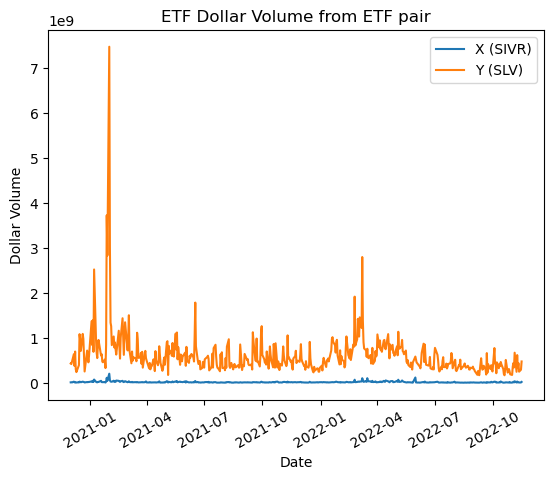

In [10]:
plt.plot(X['dollar volume'], label='X (SIVR)')
plt.plot(Y['dollar volume'], label='Y (SLV)')
plt.xlabel('Date')
plt.ylabel('Dollar Volume')
plt.title('ETF Dollar Volume from ETF pair')
plt.legend()
plt.xticks(rotation=30)

It can be seen that the dollar volume of SLV is *always* larger than the dollar volume of SIVR. As mentioned earlier, we want to use the rolling 15-trading-day median over our sample period for the less liquid ETF. Here, we will define the less liquid ETF as the one with the lower dollar volume. It is obvious that SIVR is the less liquid ETF and $N_t$ is the rolling 15-trading-day median that corresponds with X (SIVR). We will plot this next.

(array([18628., 18718., 18809., 18901., 18993., 19083., 19174., 19266.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10')])

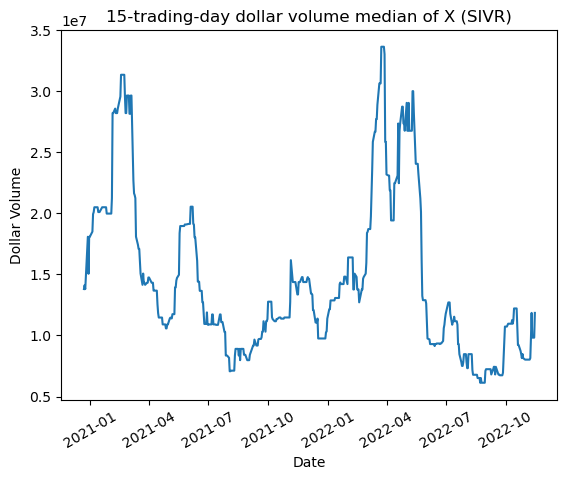

In [11]:
plt.plot(Nt)
plt.xlabel('Date')
plt.ylabel('Dollar Volume')
plt.title('15-trading-day dollar volume median of X (SIVR)')
plt.xticks(rotation=30)

This 15-trading-day dollar volume median will be used to calculate the position sizing when entering a position. This dollar volume will be the desired dollar amount for our position on a day where we decide to enter a position.

***

## 3 Exercise

We will implement our spread-reversion trading strategy in this section. We will *buy* a spread when it goes below some threshold and will *short* a spread when it goes above a threshold. We will exit these positions at some threshold (either our take-profit level or stop-loss levels). These spreads and thresholds are based off some M-day return differential between X and Y.

This strategy will begin on the first day of each month and will be allowed to trade throughout the entire month. Any open positions will then be closed on the last day of the month. We will trade off the end-of-day closing prices (which is an unrealistic assumption). There are first a few parameters we would like to define:

- *M*: Defined to be the number of days for which the return is calculated

- *z*: The difference between the M day returns of X and Y 

- *g*: The difference *z* at which we enter a position. For example, if the difference in the M day returns is above 0.001, we will enter a short spread position. If the difference is below -0.001, we will enter a long spread position.

- *j*: The difference *j* at which we close a position for profit. For example, if we are in a short position and the difference *z* reaches 0.0005, we will flatten our position.

- *s*: The proportion *s* at which we close a position for a loss. If we experience a day such that we lose more than a proportion *s* of our initial investment $|\$\text{long}| + |\$\text{short}|$, we will close our position at the current prices. We will assume no new positions for the remainder of the month.

We will only hold at most one long and one short position (one spread position). If we already have a position, we will keep holding it until we either reach our take-profit level, stop-loss level, or it is the end of the month and we are forced to liquidate our position. If *z* is large enough, we are allowed to reverse our position. Our position size will be defined to be equal dollar amounts of X and Y to the nearest integer number of shares, with the dollar price as close to $\$N_t / 100$. Our position size will not be adjusted unless we are entering new positions or reversing positions.

We will also keep track of our cumulative PnL as well as our open PnL. We will define our total initial capital *K* to be the maximum of $2  N_t$ over the data period. This is also a bad assumption as it is essentially looks into the future. 

***

**3.1 M day returns**

We will first create a function `returns` that calculates the M day returns for a given ticker. This will allow us to make our initial observations about our strategy as well as functionalize our code for other values of M later on.

In [12]:
def returns(ticker, M):
    '''
    Obtains M day returns for a ticker 

    Parameters:
        ticker (DataFrame): DataFrame of the adjusted close prices of a ticker 
        M (int): The time-period over which the returns are calculated

    Returns:
        rets (DataFrame): DataFrame consisting of M-day returns with NaN values dropped and date as index
    '''
    rets = ticker['adj_close'].pct_change(periods=M).to_frame('Returns').dropna()
    return rets

For the rest of this section, we will use $M = 5$ to keep things consistent. We will first plot these returns together to examine their relationship.

In [13]:
rets = pd.concat([returns(X, 5), returns(Y, 5)], axis=1)
rets.columns = ['X (SIVR)', 'Y (SLV)']

Text(0.5, 1.0, '5-day Returns of X (SIVR) and Y (SLV)')

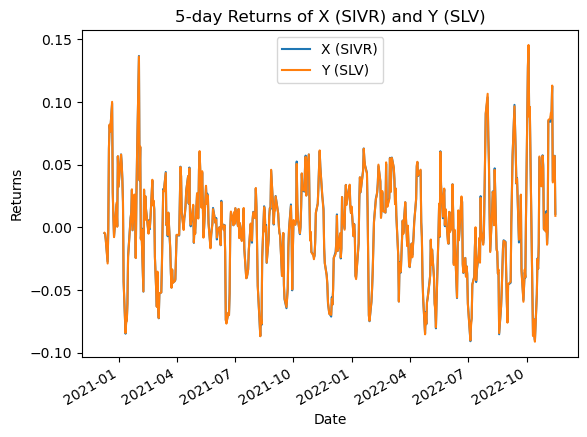

In [14]:
rets.plot()
plt.ylabel('Returns')
plt.xlabel('Date')
plt.title('5-day Returns of X (SIVR) and Y (SLV)')

From looking at the plot of returns, we notice a few things. First, they appear to be perfectly correlated. This makes sense. We saw a correlation of 1.0 when looking at the prices, so a similar degree of correlation is expected when looking at the returns (which are derived from the prices). We will once again quantify this for the sake of completeness.

In [15]:
corr = rets['X (SIVR)'].corr(rets['Y (SLV)'])
f'Correlation between 5-day returns of X (SIVR) and Y (SLV): {round(corr,3)}'

'Correlation between 5-day returns of X (SIVR) and Y (SLV): 1.0'

We see that the correlation between the return series is 1.0. Another thing that we should check for is stationarity. If the data is stationary, it means that the mean and variance are not changing in time. In fact, we can say that the returns are mean-reverting and our strategy makes sense to even consider in the first place. We will quantitatively test this with the Augmented Dickey-Fuller test.

In [16]:
X_s = adfuller(rets['X (SIVR)'])
Y_s = adfuller(rets['Y (SLV)'])

print('X (SIVR) 5-day returns ADF p-value: {:0.2e}'.format(X_s[1]))
print('Y (SLV) 5-day returns ADF p-value: {:0.2e}'.format(Y_s[1]))

X (SIVR) 5-day returns ADF p-value: 2.56e-08
Y (SLV) 5-day returns ADF p-value: 2.44e-08


The p-values are extremely small. This means that we have evidence to support the alternative hypothesis that the return series is stationary. It makes sense to look further into the spread trading strategy. If the return spread differential sways too far from the mean, we can enter in a position and exit when it converges back to the mean. We will now look at some univariate statistics for both X (SIVR) and Y (SLV). It is good to note that these statistics are not as meaningful as we care about the differential, not the absolute values. Regardless, we will still look at these statistics.

In [17]:
rets.describe()

,X (SIVR),Y (SLV)
count,488.000000,488.000000
mean,-0.000484,-0.000512
std,0.039752,0.039865
min,-0.090954,-0.091351
25%,-0.024736,-0.024793
50%,0.001189,0.001458
75%,0.022784,0.023116
max,0.144640,0.145562


We can see that these values are extremely close to each other, if not the same. If we wanted to be precise, a statistical test (i.e a z- or t- test) could be used. However, we saw that the returns are perfectly correlated and overlap each other on the plot, so we will skip this. 

***

**3.2 Building the return spreads**

We will now build the return spreads. In our case, we will construct our difference $ z = Y - X $. We will examine this different graphically and then also calculate some sample statistics in order to determine our strategy parameters.

In [18]:
z = (rets['Y (SLV)'] - rets['X (SIVR)']).to_frame('Return Spread')

Text(0.5, 1.0, 'Return Spread of Y (SLV) - X (SIVR)')

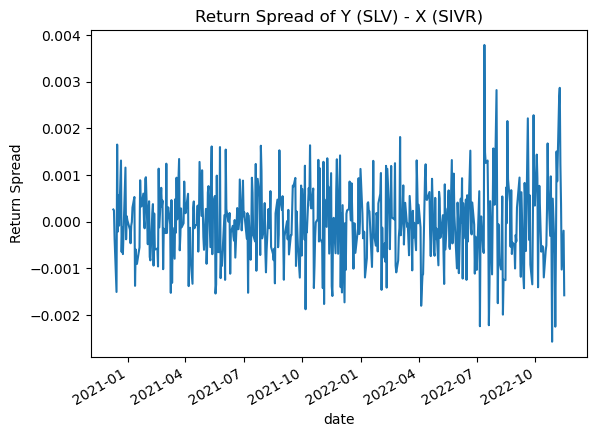

In [19]:
z.plot(legend=False)
plt.ylabel('Return Spread')
plt.title('Return Spread of Y (SLV) - X (SIVR)')

From visual inspection, the return spread also appears to be stationary. This makes sense as our spread is composed of two stationary time-series. To be precise and thorough, we will quantitatively assess this with the ADF test.

In [20]:
Z_s = adfuller(z)
print('Z (SLV - SIVR) 5-day return spread ADF p-value: {:0.2e}'.format(Z_s[1]))

Z (SLV - SIVR) 5-day return spread ADF p-value: 6.35e-09


Indeed, the return spread is also stationary, meaning that the mean and variance do not change in time. Before we examine the sample statistics, we will also look at the distribution of these spreads.

Text(0, 0.5, 'Frequency')

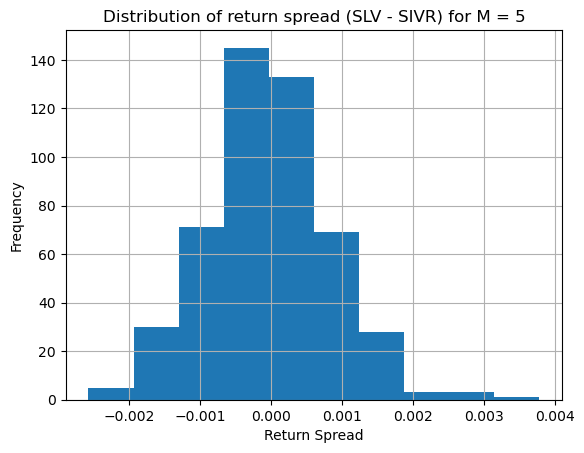

In [21]:
z.hist()
plt.title('Distribution of return spread (SLV - SIVR) for M = 5')
plt.xlabel('Return Spread')
plt.ylabel('Frequency')

The distribution looks *normalish*, but we will quantify this using the Shapiro-Wilks test.

In [22]:
z_shapiro = stats.shapiro(z['Return Spread'].values)[1]
print('Shapiro-Wilks test p-value: {:0.2e}'.format(z_shapiro))

Shapiro-Wilks test p-value: 6.09e-03


It turns out that the distribution of return spreads are not normal. We will now look at sample statistics as well as tail statistics (skewness and kurtosis). These statistics will help us determine our strategy parameters *g* and *j* for our choice of $M = 5$ 

The level of *s* is more arbitrary as it is dependent on our present position value losing some proportion of gross traded cash (the absolute value of our dollar position of shorts + longs). This metric is used as we will always be short and long when in a position and thus our position size should be roughly $0 - this metric allows us to implement a stop loss. However, also metrics could also be used (i.e s is when the return spread hitting some value based on a 0.95 quantile).

In [23]:
z.describe()

,Return Spread
count,488.000000
mean,-0.000028
std,0.000861
min,-0.002573
25%,-0.000601
50%,-0.000047
75%,0.000483
max,0.003784


From the sample statistics, it can be seen that the mean is around 0 while the interquartile range is from -0.000601 to 0.000483. These statistics tell us that we will revert back to 0, but it doesn't really help to give precise parameters to use. Instead, let's first calculate the tail statistics.

In [24]:
z_tail = pd.DataFrame(columns=['Skewness','Kurtosis'])
z_tail['Skewness'] = z.skew()
z_tail['Kurtosis'] = z.kurtosis()
z_tail

,Skewness,Kurtosis
Return Spread,0.300921,0.836293


These empirical skewness and kurtosis values tell us that our empirical distribution is skewed slightly to the right (symmetrical / normal distributions have skews of 0). The kurtosis tells us that there is more probability mass in the tail regions when compared to a normal distribution. We will use the empirical distribution rather than an approximated normal distribution for the rest of the notebook. Since we are both buying and shorting the spreads, it may be more useful to plot the absolute value of the return spread to determine our parameters. 

Text(0.5, 0, 'Absolute Value of Return Spread')

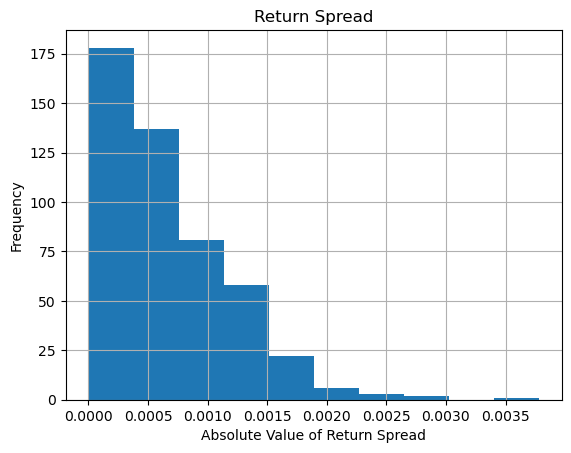

In [25]:
abs_z = z.abs()
z.abs().hist()
plt.ylabel('Frequency')
plt.xlabel('Absolute Value of Return Spread')

We can see that the absolute value of return spread can help us determine parameters to use for entries while the normal return spreads can help us determine our take-profit levels. To be more specific, we will use certain quantiles to determine these parameters. We will use the 80th percentile of the absolute return spread for our entry.

In [26]:
g = abs_z.quantile(.8).item()
f'Return Spread Difference g: {round(g,4)}'

'Return Spread Difference g: 0.0011'

For calculating our take-profit level, we will use the normal return spread empirical distribution. Our choice will be to average the absolute values of the 25- and 75th percentiles. We do this because our distribution is approximately symmetric, and these quantiles should be relatively equal. These values will also give us a take-profit level that is easily reached.

In [27]:
j = (z.quantile(.25).abs() + z.quantile(.75).abs()).item()/2
f'Return Spread Difference j: {round(j,4)}'

'Return Spread Difference j: 0.0005'

In [28]:
s = 0.05

Thus, our chosen parameters will be $g \approx 0.001$ and $j \approx 0.0005$. For s, we will arbitrarily choose this to be **0.05**. In other words, if we lose 5% of our gross-traded cash, we will exit the position at the current prices and stay out of trades for the rest of the month.

***

**3.3 Simulating the strategy**

We will now backtest the strategy. The strategy begins on the first day of each month. However, our dataset starts on December 02 2020, so the first day of our strategy will begin after January 01 2021. This also is good as it allows no NaN data from either the M-day return series or the 15-day rolling dollar volume median. We will create a function that returns a series of positions, PnLs, and general strategy statstics given the series of return spreads. This allows for functionality later with other parameters (or pairs). We also assume our initial capital $K$ to be the maximum of $2 N_t$, though this really has no effect on the results as the portfolio value can be simply added to the cumulative PnL (we do not define this in the code until the next section). 

In [29]:
def simulate(X, Y, M, g, j, s,date='2021-01-01'):
    '''
    Obtains position data given a series of return of ETFs and chosen parameter M 

    Parameters:
        X (DataFrame): Price data of ETF X 
        Y (DataFrame): Price data of ETF Y 
        M (int): Number of days for the return-spread series 
        date (string): Date where you want to start the simulation from (defaults 2021-01-01)

    Returns:
        pos (DataFrame): DataFrame consisting of position sizes of X and Y for each date 
        stats (DataFrame): DataFrame detailing number of trades and number of times stopped out
        pnl (DataFrame): DataFrame giving the open, daily, and cumulative PnLs
    '''
    z = (returns(Y[['adj_close']],M) - returns(X[['adj_close']],M))
    z = z.loc[date:]

    pos = pd.DataFrame(data=0, index=z.index, columns=['X','Y'])
    stats = pd.DataFrame(columns=['Quantity'],index=['Number of Trades', 'Stopped Trades'])
    pnl = pd.DataFrame(data=0, index=z.index,columns=['Open PnL','Daily PnL','Cumulative PnL'])
    
    num_trades = 0 
    stopped = 0
    for date, data in z.groupby(z.index.to_period('M')):
        num_days = len(data)
        long_X = 0
        cur_pos = [0, 0]

        threshold = 0 
        cur_value = 0 
        initial_value = 0 
        prev_value = 0
        new_pos = False 

        for d in range(num_days-1):
            date = data.iloc[d].name
            ret = data.iloc[d]['Returns']
            X_price = prices.loc[date, 'X']
            Y_price = prices.loc[date, 'Y']

            dollar_amt = Nt.loc[date].item() / 100 
            X_amt = round(dollar_amt / X_price)
            Y_amt = round(dollar_amt / Y_price)

            if new_pos != True:
                prev_value = cur_value 
            else:
                prev_value = initial_value 
                new_pos = False 

            cur_value = np.dot(cur_pos, [X_price, Y_price])
            
            pnl.loc[date, 'Open PnL'] = cur_value - initial_value 
            pnl.loc[date, 'Daily PnL'] = cur_value - prev_value 

            if long_X != 0 and (cur_value - initial_value) <= threshold:
                pos.loc[date] = cur_pos 
                long_X = 0
                stopped += 1 
                break 

            if np.abs(ret) > g:
                if ret > 0 and long_X != 1:
                    cur_pos = [X_amt, -Y_amt]
                    threshold = -s * np.abs(cur_pos) @ [X_price, Y_price]
                    initial_value = np.dot(cur_pos, [X_price, Y_price])
                    num_trades += 1 
                    long_X = 1 
                    new_pos = True 
                elif ret < 0 and long_X != -1:
                    cur_pos = [-X_amt, Y_amt]
                    threshold = -s * np.abs(cur_pos) @ [X_price, Y_price]
                    initial_value = np.dot(cur_pos, [X_price, Y_price])
                    num_trades += 1
                    long_X = -1 
                    new_pos = True 
                elif long_X != 0:
                    pos.loc[date] = cur_pos 
            elif (long_X == 1 and ret < j) or (long_X == -1 and ret > -j):
                pos.loc[date] = cur_pos 
                long_X = 0 
                cur_pos = [0, 0]
                cur_value = 0
                initial_value = 0
            else:
                if long_X != 0:
                    pos.loc[date] = cur_pos 
        
        if long_X != 0:
            pos.loc[data.iloc[d+1].name] = cur_pos

    pnl['Cumulative PnL'] = pnl['Daily PnL'].cumsum()
    stats['Quantity'] = [num_trades, stopped]
    return pos, stats, pnl

In [30]:
positions, stats, pnl = simulate(X, Y, 5, g, j, s)

We now have a DataFrame of the positions, trade stats, and PnL we have at the end of each trading day. 

***

**3.4 PnL Plots**

Since we have a DataFrame with all the different PnLs. We will look at them in this section. First, we will set out capital amounts so we can see how our portfolio grows. Note, this has a lookahead issue. This is just to prevent any issues with negative capital (and to make sure we don't lose all our capital).

In [31]:
K = 2 * Nt.max()
f'Initial capital: {K}'

'Initial capital: 67290128.28'

Text(0.5, 1.0, 'Daily PnL for M = 5 Return Spreads')

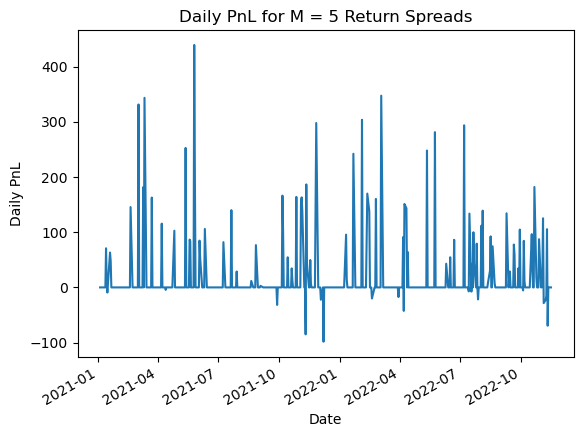

In [32]:
pnl['Daily PnL'].plot()
plt.xlabel('Date')
plt.ylabel('Daily PnL')
plt.title('Daily PnL for M = 5 Return Spreads')

Text(0.5, 1.0, 'Open PnL for M = 5 Return Spreads')

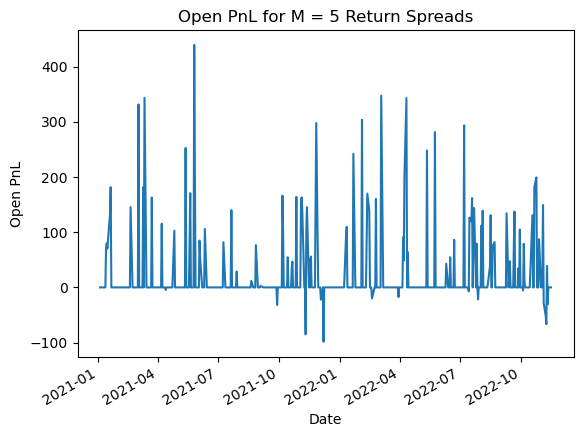

In [33]:
pnl['Open PnL'].plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Open PnL')
plt.title('Open PnL for M = 5 Return Spreads')

It can be seen that our Open and Daily PnL charts look extremely similar. This is likely due to the fact that our spread converges to the mean extremely rapidly and many trades aren't open for very long (potentially 1 day).

Text(0.5, 1.0, 'Cumulative PnL for M = 5 Return Spreads')

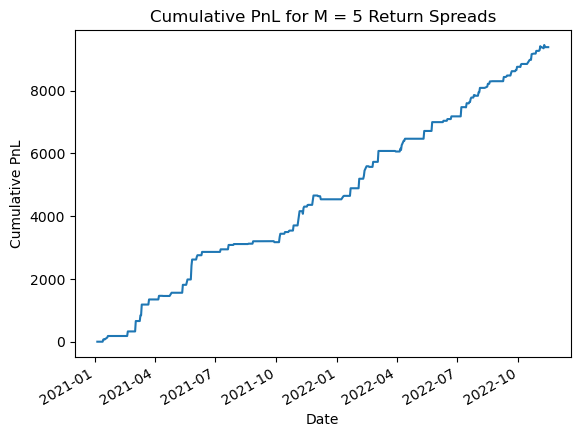

In [34]:
pnl['Cumulative PnL'].plot()
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL for M = 5 Return Spreads')

We see that in general, the strategy seems to perform fairly well. It has a general uptrend. For curiosity, let's see how many trades we took and how many times we got stopped out.

In [35]:
print('Number of Taken Trades: ' + str(stats.loc['Number of Trades'].item()))
print('Times Stopped Out: ' + str(stats.loc['Stopped Trades'].item()))

Number of Taken Trades: 76
Times Stopped Out: 0


It is interesting to see that we took 76 trades and we were stopped out 0 times. Let's see what type of threshold we need to get stopped out. Let's see how long it takes before we get stopped out.

In [36]:
s = .05
stopped_test = 0 
while stopped_test == 0:
    _, stats, _ = simulate(X, Y, 5, g, j, s)
    stopped_test = stats.loc['Stopped Trades'].item()
    s /= 2

print('Required s to get stopped out: {:0.2e}'.format(s))

Required s to get stopped out: 1.95e-04


We see that we need an extremely low threshold in order to get stopped out. This could be explained by the magnitude of gross capital traded (abs. value of long and short dollar positions) and the fact that the ETFs have a perfect correlation, so return discrepencies are immediately reverted.

***

**3.5 Portfolio Metrics**

We will characterize the performance of our strategy with a few metrics. We will look at the Sharpe Ratio of our *dynamic portfolio* of spreads and correlation between the returns of our strategy vs. that of the ETFs. We will create a function to calculate certain portfolio metrics. Before we can use the function, we need to convert our cumulative PnL into a time-series of our portfolio value. This is simple: we just need to add our initial capital to the cumulative PnL. 

In [37]:
def metrics(port):
    metrics = pd.DataFrame()
    rets = port.pct_change()
    metrics['Mean'] = 12 * rets.mean()
    metrics['Volatility'] = np.sqrt(12) * rets.std()
    metrics['Sharpe Ratio'] = np.sqrt(12) * rets.mean() / rets.std()
    return metrics

In [38]:
portfolio = (pnl['Cumulative PnL'] + K).to_frame('Return-Spread Portfolio')
portfolio_x = prices['2021-01-01':][['X']]
portfolio_y = prices['2021-01-01':][['Y']]
port_comp = pd.concat([portfolio, portfolio_x, portfolio_y],axis=1)

metrics(port_comp)

,Mean,Volatility,Sharpe Ratio
Return-Spread Portfolio,0.000004,0.000003,1.153368
X,-0.004227,0.061428,-0.068813
Y,-0.004303,0.061590,-0.069871


We see that our return-spread portfolio has a much higher Sharpe Ratio than holding either one of the ETFs by itself. Although it has a high Sharpe Ratio, the mean and volatility are also extremely low, meaning that we require a lot of capital for this strategy to be viable.

In [39]:
pct_gain = 100 * (pnl['Cumulative PnL'][-1] / K)
f'Percent gain: {round(pct_gain,4)}'

'Percent gain: 0.0139'

We see that our percent gain is 0.0139% over a 2-year interval, which is extremely low. We'll also look at the correlation between the returns of our return-spread portfolio and that of the returns of ETF X and Y.

In [40]:
corr_x = portfolio['Return-Spread Portfolio'].pct_change().corr(portfolio_x['X'].pct_change())
corr_y = portfolio['Return-Spread Portfolio'].pct_change().corr(portfolio_y['Y'].pct_change())

print('Correlation between Return-Spread Portfolio and SIVR: ' + str(round(corr_x, 3)))
print('Correlation between Return-Spread Portfolio and SLV: ' + str(round(corr_y, 3)))

Correlation between Return-Spread Portfolio and SIVR: -0.004
Correlation between Return-Spread Portfolio and SLV: -0.008


We see that the correlation between our portfolio returns and that of the ETFs is essentially 0, indicating that there is basically no correlation between the returns of the ETFs and that of the spreads, which makes sense. 

***

## 4 Analysis

In this section, we will try to find values of parameters that give us the best performance. As a reminder, these parameters are:

- *M*: Defined to be the number of days for which the return is calculated

- *g*: The difference *z* at which we enter a position. For example, if the difference in the M day returns is above 0.001, we will enter a short spread position. If the difference is below -0.001, we will enter a long spread position.

- *j*: The difference *j* at which we close a position for profit. For example, if we are in a short position and the difference *z* reaches 0.0005, we will flatten our position.

- *s*: The proportion *s* at which we close a position for a loss. If we experience a day such that we lose more than a proportion *s* of our initial investment $|\$\text{long}| + |\$\text{short}|$, we will close our position at the current prices. We will assume no new positions for the remainder of the month.

We will use many of the same functions from above, notably `simulate()` and `metrics()`. We will use some of the same methods we used to calculate our parameters of *g* and *j*. We will change these values to be the certain quantiles from our empirical distribution. We will use a grid-search to find the values (corresponding to certain quantiles) that yield the best results.

---


**4.1 Optimizing Parameters**

We will create a grid of M, G, J, and S values and determine the best values. Our metric for the *best performance* will be the one with the highest Sharpe Ratio. These grid values will range from M = 2, 46 in intervals of 5, G = 0.6 to 0.98 with intervals of 0.05, J = 0.1 to 0.46 with intervals of 0.05. 

After running the simulation a few times, it was seen that the value of *s* almost irrelevant to the results. As seen above, the threshold of *s* needs to be extremely small for it to make a difference. This value of s is unrealistic in real-life settings. In this case, *s* was set to a constant value of 0.05 for computation speed.

In [41]:
M = np.arange(1,46,5)
G = np.arange(.6,.98,.05)
J = np.arange(.1,.46,.05)
s = 0.05 

In [42]:
heap = []
unique_sr = []

for m in M:
    for gq in G:
        for jq in J:
            z = returns(Y,m) - returns(X,m)
            g = z.abs().quantile(gq).item()
            j = (z.quantile(jq).abs().item() + z.quantile(1-jq).item()) / 2 
            pos_size, _, pnl = simulate(X,Y,m,g,j,.05)
            portfolio_val = pnl['Cumulative PnL'] + K 
            rets = portfolio_val.pct_change()
            sr = np.sqrt(12) * rets.mean() / rets.std()
            params = (m, g, j)

            if sr not in unique_sr:
                unique_sr.append(sr)
                heappush(heap, (sr, params))

After running this grid, it was also seen that some parameters would yield the same Sharpe, perhaps due to the discrete nature of the time-series and some thresholds essentially being equivalent. To remedy this, a unique check was added to only add unique Sharpes to the heap.

In [43]:
top_4_values = nlargest(4, heap)
for i in range(len(top_4_values)):
    print('SR: ' + str(top_4_values[i][0]), '(m, g, j): ' + str(top_4_values[i][1]))

SR: 1.4206913172511404 (m, g, j): (21, 0.0006851646969936451, 0.00039690573379648204)
SR: 1.404842026612749 (m, g, j): (1, 0.00071075654544841, 9.233627311170626e-05)
SR: 1.3996100748367188 (m, g, j): (21, 0.0006851646969936451, 0.0010517697774673263)
SR: 1.386198002753159 (m, g, j): (21, 0.0006851646969936451, 0.000528518992814378)


We see that the top 4 highest Sharpes with the chosen grid range from 1.39 to 1.42. We will now analyze these strategies a little more. 

The highest j corresponds to a value of about 0.0004 while the highest g corresponds to around 0.0069, meaning there is a 0.002 minimum difference between entry and exit. It is interesting to note that the j for the second highest SR is extremely low (almost equal to 0).

***

**4.2 Highest Sharpe Ratio Strategies**

We will first plot the cumulative PnLs by resimulating the PnLs with the respective parameters. 

In [44]:
cum_pnl_sr = pd.DataFrame(index=pnl.index,columns=[1.42, 1.40, 1.39, 1.38])
trade_stats = pd.DataFrame(columns=[1.42, 1.40, 1.39, 1.38],index=['Number of Trades', 'Stopped Trades'])
for i in range(len(top_4_values)):
    params = top_4_values[i]
    m, g, j= params[1][0], params[1][1], params[1][2]
    pos_size, stats, pnl = simulate(X,Y,m,g,j,.05)
    trade_stats[trade_stats.columns[i]] = stats
    cum_pnl_sr[cum_pnl_sr.columns[i]] = pnl['Cumulative PnL']

Text(0.5, 1.0, 'Cumulative PnL with varying SRs')

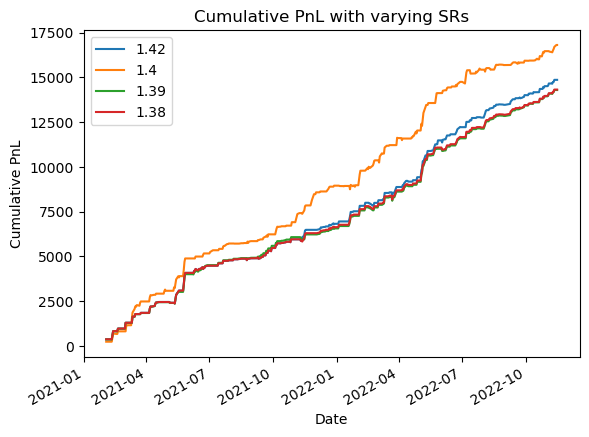

In [45]:
cum_pnl_sr.plot()
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL with varying SRs')

It's interesting to note that a higher Sharpe doesn't always correspond with a higher cumulative PnL. The Sharpe of 1.4 actually has the highest PnL while the highest Sharpe has the second highest PnL. We'll now look at how to Sharpe Ratio is actually built.

In [46]:
sr_port = K + cum_pnl_sr
metrics(sr_port)

,Mean,Volatility,Sharpe Ratio
1.42,0.000006,0.000004,1.420931
1.40,0.000007,0.000005,1.420528
1.39,0.000006,0.000004,1.399530
1.38,0.000006,0.000004,1.385063


We see what we saw earlier. Although the Sharpe Ratio is high, it has extremely small means and volatilities. We'll now look at the number of trades and the times that we got stopped in each of the trades.

In [47]:
trade_stats

,1.42,1.40,1.39,1.38
Number of Trades,138,171,141,138
Stopped Trades,0,0,0,0


We see that all the strategies took a similar number of trades. The SR = 1.40 strategy took the most trades while the SR = 1.42 strategy took 138 trades. More trades does not mean a better strategy, which can also be applied to real trading strategies. 

We'll now examine how these strategies correlate with Fama-French factors.

***

**4.3 Fama-French Factor Returns**

The Fama-French factors is a pricing model that tries to explain the returns of a portfolio (or in this case, a strategy). Essentially, the (3-factor) model uses the market, size, and value premiums to explain market returns. We will examine the correlation between our strategy returns and that of the Fama-French model. We will first import the data and examine it. 

If you want to download the same dataset, look in section 2.1 for instructions.

In [130]:
factors = get_ff('fama_french_factors.csv')['2021-01-01':]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2021-01-04,-1.41,0.22,0.58,0.0
2021-01-05,0.86,1.23,0.48,0.0
2021-01-06,0.79,2.14,3.93,0.0
2021-01-07,1.76,0.33,-0.83,0.0
2021-01-08,0.51,-0.75,-1.38,0.0


We will now calculate the correlations between our top 4 strategies and the Fama-French factors.

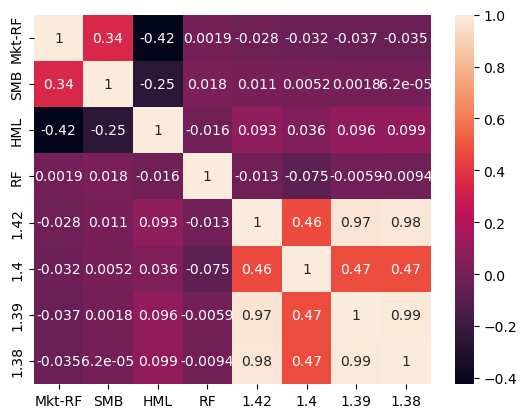

In [131]:
df = pd.concat([factors, sr_port.pct_change()],axis=1)
corr_mat = sns.heatmap(df.corr(), annot=True)

First, we'll look at the Fama-French factors themselves. We can see that the Mkt-RF, SMB, HML, and RF factors are all relatively uncorrelated to each other. This is something we'd expect, especially for a linear-factor model.

We would expect a spread-trading strategy to be relatively uncorrelated to any broad market factors. The strategy focuses on differences between two of the same security, so it shouldn't follow the trend of something else. In other words, it should be independent. We see this with all of our strategies. The correlation to all the factors are extremely close to 0, indicating that they show almost no correlation (which is good!). It's interesting to note that the pair of HML and 1.38 has the highest correlation of 0.1, which is still extremely low. 

We would also expect that the strategies should all have similar correlations to each other. This is as expected for the most part as most of these strategies are doing the same thing. This is true for the most part as much of the correlations between the pairs are almost perfect. However, it is interesting to note that the 1.4 SR ratio has a very weak correlation of 0.47 to the other pairs. This could be due to the strategy, as the other Sharpes all have a M = 21 while this one is equal to 1.

***

## 5 Conclusion

In this assignment, a spread trading strategy was created and backtested on a silver ETF pair (SIVR and SLV). The spread was created in the following fashion: the M day returns were calculated for each of the ETFs and the spread was formed as the difference between ETF Y and ETF X (SLV - SIVR). Whenever the absolute value of the spread got larger than a certain threshold, we would either long or short the spread and wait for it to revert to the mean. We would then take some profits at some level. In addition, a stop loss parameter was also set such that if we lost a certain proportion of our initial gross (absolute) traded dollar amount, we would immediately close the position. Our position size was determined by the 15-day rolling dollar volume median of the less-liquid security. In this case, that security was SIVR.

First, statistical measures were done on the spreads to ensure that they were stationary. We also looked at the distribution of the spread and found that although they appeared normal, they were empirically not. Thus, we used the empirical distribution for many of the calculations. To initially determine our parameters, we established these parameters based off the quantile of the absolute distribution of spreads or the non-absolute distribution of spreads. These were the values that corresponded to certain quantiles based on the empirical distribution of some value M. In other words, the values of *j* and *g* were dependent on M. 

A grid-search was performed to determine the parameters that yielded the best strategy performance. Our (only) metric for performance was Sharpe Ratio. The highest strategy with the highest Sharpe Ratio was considered the best. In the future, this could be repeated with other metrics. A grid was setup with certain values of m, s, j, and g and Sharpes were calculated after simulating the strategy. Interestingly, it was found that the value of *s* needed to be extremely small for trades to even get stopped out (on the order of $10^{-4}$). This could be potentially explained by the fact that the ETF pair has perfect correlation, so that changes in returns immediately always revert back. The Sharpes were calculated with a time-series of portfolio returns. The initial portfolio value was set to $2 \max(N_t)$, which is forward looking but can be improved in the future. After running the grid search, the highest Sharpe Ratio was found to be approximately 1.42, taking 138 total trades. The best strategy was to enter a trade when the absolute spread difference gets above approximately 0.0007 and exit when the spread difference falls below 0.0004.  

Finally, the returns of the strategy was compared to the Fama-French 3-factor model, a pricing model that explains returns of a portfolio (or strategy). We found that the correlation between the Fama-French factors and our strategy is almost 0. This makes sense as the strategy isn't trying to follow the market, but rather find mispricings between two securities tracking the same asset-class. Interestingly, we see that the strategy has relatively low correlation to other versions of the same strategy using different parameters. 

In the future, this strategy can be done on other ETF pairs to see the performance there. For example, the correlations between these ETFs was essentially 1, indicating perfect correlation. This strategy could be done on pairs which have lower correlations to examine the performance. Also, the initial capital requirement can be changed to not be forward looking. This may provide a better estimate on how the strategy actually performs. Right now, there is *essentially* infinite capital, which isn't translatable to real-life. This strategy could also be applied to multiple ETF pairs. In other words, trying SIVR / SLV as well as another pair. Right now, there is a good Sharpe Ratio but the mean and volatility are too low for this to be applicable and may not even cover the transaction fees; these steps could potentially make the strategy for applicable to real-life situations.

